In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import os
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
sns.set_style("whitegrid")
pd.set_option('display.max_columns', 100)
%matplotlib inline
print("Libraries imported successfully!")

Libraries imported successfully!


In [1]:
def load_data():
    try:
        ratings = pd.read_csv('allbut.pl', sep='\t', 
                            names=['user_id', 'movie_id', 'rating', 'timestamp'],
                            encoding='latin-1')
        
        movies = pd.read_csv('mku.sh', sep='|',
                           names=['movie_id', 'title', 'genres'],
                           encoding='latin-1')

        try:
            users = pd.read_csv('u.user', sep='|',
                              names=['user_id', 'age', 'gender', 'occupation', 'zip_code'],
                              encoding='latin-1')
        except:
            users = None
            print("u.user file not found - proceeding without user demographics")
        
        return ratings, movies, users
    
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        print("Please ensure allbut.pl and mku.sh exist in your directory")
        print("Current directory contents:", os.listdir())
        return None, None, None

In [28]:
def load_real_data():
    """Load the actual MovieLens data files"""
    try:
        ratings = pd.read_csv('u.data', sep='\t',
                            names=['user_id', 'movie_id', 'rating', 'timestamp'],
                            encoding='latin-1')
        
        movies = pd.read_csv('u.item', sep='|',
                           names=['movie_id', 'title', 'release_date', 'video_release_date',
                                 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation',
                                 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
                                 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
                                 'Thriller', 'War', 'Western'],
                           encoding='latin-1')
        
        try:
            users = pd.read_csv('u.user', sep='|',
                              names=['user_id', 'age', 'gender', 'occupation', 'zip_code'],
                              encoding='latin-1')
        except:
            users = None
            print("u.user not found - proceeding without user data")
            
        return ratings, movies[['movie_id', 'title']], users
    
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        print("Please ensure u.data and u.item are in your directory")
        print("Download from: http://files.grouplens.org/datasets/movielens/ml-100k.zip")
        return None, None, None

ratings, movies, users = load_real_data()

if ratings is not None and movies is not None:
    print("Data loaded successfully!")
    print(f"Ratings: {ratings.shape[0]} records")
    print(f"Movies: {movies.shape[0]} titles")
    
    print("\nData validation:")
    print("Unique users:", ratings['user_id'].nunique())
    print("Unique movies:", ratings['movie_id'].nunique())
    print("Rating range:", ratings['rating'].min(), "to", ratings['rating'].max())
    
    user_item_matrix = ratings.pivot_table(
        index='user_id',
        columns='movie_id',
        values='rating'
    ).fillna(0)
    
    print("\nUser-item matrix created successfully!")
    print(f"Dimensions: {user_item_matrix.shape[0]} users x {user_item_matrix.shape[1]} movies")
else:
    print("Failed to load data - please check the error message above")

Data loaded successfully!
Ratings: 100000 records
Movies: 1682 titles

Data validation:
Unique users: 943
Unique movies: 1682
Rating range: 1 to 5

User-item matrix created successfully!
Dimensions: 943 users x 1682 movies


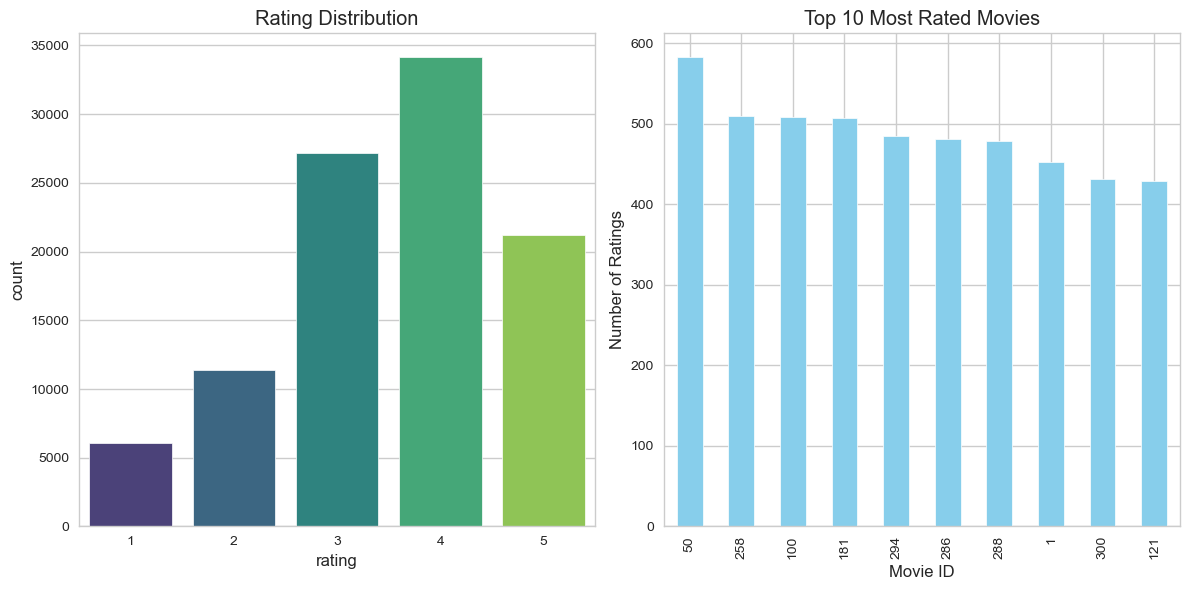

In [30]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.countplot(x='rating', data=ratings, palette='viridis')
plt.title('Rating Distribution')

top_movies = ratings['movie_id'].value_counts().head(10)
plt.subplot(1, 2, 2)
top_movies.plot(kind='bar', color='skyblue')
plt.title('Top 10 Most Rated Movies')
plt.xlabel('Movie ID')
plt.ylabel('Number of Ratings')

plt.tight_layout()
plt.show()

In [32]:
user_item_matrix = ratings.pivot_table(
    index='user_id',
    columns='movie_id',
    values='rating'
).fillna(0)

print("User-Item Matrix created successfully!")
print(f"Dimensions: {user_item_matrix.shape[0]} users x {user_item_matrix.shape[1]} movies")

from scipy.sparse import csr_matrix
sparse_matrix = csr_matrix(user_item_matrix.values)

User-Item Matrix created successfully!
Dimensions: 943 users x 1682 movies


In [46]:
def user_based_recommend(user_id, n=5):
    try:
        user_similarity = cosine_similarity(user_item_matrix)
        user_sim_df = pd.DataFrame(user_similarity, 
                                 index=user_item_matrix.index, 
                                 columns=user_item_matrix.index)
        
        similar_users = user_sim_df[user_id].sort_values(ascending=False)[1:11]
        
        similar_users_ratings = user_item_matrix.loc[similar_users.index]
        weighted_ratings = similar_users_ratings.mul(similar_users, axis=0)
        predicted_ratings = weighted_ratings.sum(axis=0) / similar_users.sum()
        
        user_rated = user_item_matrix.loc[user_id]
        unseen_movies = user_rated[user_rated == 0].index
        recommendations = predicted_ratings[unseen_movies].sort_values(ascending=False).head(n)
        
        return recommendations
    
    except Exception as e:
        print(f"Error generating recommendations: {str(e)}")
        return None

In [48]:
def item_based_recommend(user_id, n=5):
    try:
        item_similarity = cosine_similarity(user_item_matrix.T)
        item_sim_df = pd.DataFrame(item_similarity,
                                 index=user_item_matrix.columns,
                                 columns=user_item_matrix.columns)
        
        user_ratings = user_item_matrix.loc[user_id]
        rated_movies = user_ratings[user_ratings > 0].index
        
        recommendations = pd.Series()
        for movie in user_item_matrix.columns:
            if user_ratings[movie] == 0:
                similar_movies = item_sim_df[movie][rated_movies]
                similar_ratings = user_ratings[rated_movies]
                predicted_rating = (similar_movies * similar_ratings).sum() / similar_movies.sum()
                recommendations[movie] = predicted_rating
        
        return recommendations.sort_values(ascending=False).head(n)
    
    except Exception as e:
        print(f"Error generating recommendations: {str(e)}")
        return None

In [50]:
def svd_recommend(user_id, n=5, factors=50):
    try:
        R = user_item_matrix.values
        user_ratings_mean = np.mean(R, axis=1)
        R_demeaned = R - user_ratings_mean.reshape(-1, 1)
        
        U, sigma, Vt = svds(R_demeaned, k=factors)
        sigma = np.diag(sigma)
        
        all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
        preds_df = pd.DataFrame(all_user_predicted_ratings,
                              columns=user_item_matrix.columns,
                              index=user_item_matrix.index)
        
        user_ratings = user_item_matrix.loc[user_id]
        unseen_movies = user_ratings[user_ratings == 0].index
        recommendations = preds_df.loc[user_id][unseen_movies].sort_values(ascending=False).head(n)
        
        return recommendations
    
    except Exception as e:
        print(f"Error generating recommendations: {str(e)}")
        return None

In [52]:
def evaluate_recommendations(user_id, recommendations, k=5, threshold=3.5):
    try:
        # Get user's high-rated movies
        user_ratings = ratings[ratings['user_id'] == user_id]
        actual_high_rated = user_ratings[user_ratings['rating'] >= threshold]['movie_id'].values

        recommended_movies = recommendations.index[:k]
        
        hits = len(set(recommended_movies) & set(actual_high_rated))
        return hits / k
    
    except Exception as e:
        print(f"Error in evaluation: {str(e)}")
        return 0

In [54]:
def load_data():
    try:
        ratings = pd.read_csv('u.data', sep='\t', 
                            names=['user_id', 'movie_id', 'rating', 'timestamp'],
                            encoding='latin-1')
        
        movies = pd.read_csv('u.item', sep='|', 
                           names=['movie_id', 'title', 'release_date', 'video_release',
                                 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation',
                                 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
                                 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
                                 'Thriller', 'War', 'Western'],
                           encoding='latin-1')
        
        genre_columns = movies.columns[5:] 
        movies['genres'] = movies[genre_columns].apply(
            lambda row: '|'.join([col for col, val in zip(genre_columns, row) if val == 1]),
            axis=1
        )
        
        movies = movies[['movie_id', 'title', 'genres']]
        
        return ratings, movies, None 
    
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None, None, None

In [56]:
def display_recommendations(user_id):
    print(f"\nRecommendations for User {user_id}:")
    
    def safe_display(recommendations, method_name):
        if recommendations is None:
            print(f"{method_name}: Could not generate recommendations")
            return
        
        try:
            merged = recommendations.to_frame('Predicted Rating').merge(
                movies, 
                left_index=True, 
                right_on='movie_id'
            )
            
            available_cols = ['title', 'Predicted Rating']
            if 'genres' in merged.columns:
                available_cols.append('genres')
            
            display(merged[available_cols])
            
        except Exception as e:
            print(f"{method_name}: Error displaying recommendations - {str(e)}")
            print("Recommendations:", recommendations.head())
    
    print("\nUser-Based Collaborative Filtering:")
    safe_display(user_based_recommend(user_id), "User-Based")
    
    print("\nItem-Based Collaborative Filtering:")
    safe_display(item_based_recommend(user_id), "Item-Based")
    
    print("\nMatrix Factorization (SVD):")
    safe_display(svd_recommend(user_id), "SVD")


display_recommendations(1) 


Recommendations for User 1:

User-Based Collaborative Filtering:


,title,Predicted Rating
317,Schindler's List (1993),4.088954
473,Dr. Strangelove or: How I Learned to Stop Worr...,3.904887
654,Stand by Me (1986),3.696039
422,E.T. the Extra-Terrestrial (1982),3.691327
402,Batman (1989),3.678409



Item-Based Collaborative Filtering:


,title,Predicted Rating
1155,Cyclo (1995),4.382759
1600,Office Killer (1997),4.240827
1655,Little City (1998),4.234926
1592,Death in Brunswick (1991),4.224473
1673,Mamma Roma (1962),4.178130



Matrix Factorization (SVD):


,title,Predicted Rating
422,E.T. the Extra-Terrestrial (1982),3.509642
402,Batman (1989),3.097894
731,Dave (1993),2.971226
356,One Flew Over the Cuckoo's Nest (1975),2.752628
384,True Lies (1994),2.605706


In [58]:
def evaluate_all_methods(user_id, k=5):
    results = {}
    
    ub_rec = user_based_recommend(user_id)
    if ub_rec is not None:
        results['User-Based'] = evaluate_recommendations(user_id, ub_rec, k)
    
    ib_rec = item_based_recommend(user_id)
    if ib_rec is not None:
        results['Item-Based'] = evaluate_recommendations(user_id, ib_rec, k)
    
    svd_rec = svd_recommend(user_id)
    if svd_rec is not None:
        results['SVD'] = evaluate_recommendations(user_id, svd_rec, k)
    
    if results:
        print(f"\nPrecision@{k} for User {user_id}:")
        for method, score in results.items():
            print(f"{method}: {score:.2f}")
    else:
        print("Could not evaluate any methods")

evaluate_all_methods(1) 


Precision@5 for User 1:
User-Based: 0.00
Item-Based: 0.00
SVD: 0.00


In [62]:
import joblib

def save_models():
    try:
        joblib.dump(user_item_matrix, 'user_item_matrix.pkl')
        print("Models saved successfully!")
    except Exception as e:
        print(f"Error saving models: {str(e)}")

def load_models():
    try:
        global user_item_matrix
        user_item_matrix = joblib.load('user_item_matrix.pkl')
        print("Models loaded successfully!")
        return True
    except Exception as e:
        print(f"Error loading models: {str(e)}")
        return False

save_models()
load_models()

Models saved successfully!
Models loaded successfully!


True